In [18]:
import sys 
import os
import polars as pl 
import re
import matplotlib.pyplot as plt
project_root = os.path.dirname(os.getcwd())
sys.path.insert(0, project_root)
from utils.config import config
from utils.io import read_data
from clifpy.utils.stitching_encounters import stitch_encounters

site_name = config['site_name']
tables_path = config['tables_path']
file_type = config['file_type']
print(f"Site Name: {site_name}")
print(f"Tables Path: {tables_path}")
print(f"File Type: {file_type}")

Site Name: UCMC
Tables Path: /Users/dema/WD/CRI_2018_24/BOX_2.1.0/2.1.0
File Type: parquet


# Load data

In [19]:
relevant_cohort_with_deathage = pl.read_parquet("../output/intermediate/relevant_cohort_with_deathage.parquet")

In [20]:
relevant_cohort_with_deathage.head()

patient_id,hospitalization_id,encounter_block,age_at_death
str,str,i32,f64
"""32224""","""633553353""",109151,54.154689
"""36006""","""632786319""",112540,40.424367
"""218677""","""645145968""",78912,59.912389
"""103701""","""644852604""",5123,88.418891
"""72298""","""633633847""",143065,59.47707


In [21]:
hospital_dx_filepath = f"{tables_path}/clif_hospital_diagnosis.{file_type}"
hosp_dx_df = read_data(hospital_dx_filepath, file_type)

File name: clif_hospital_diagnosis.parquet
Time taken to load the dataset: 0.01 seconds
Size of the loaded dataset: 48.41 MB



In [22]:
# Filter hosp_dx_df hospital_ids to those in relevant_cohort_with_deathage
relevant_hosp_ids = relevant_cohort_with_deathage.get_column("hospitalization_id").unique()
hosp_dx_df = hosp_dx_df.filter(
    pl.col("hospitalization_id").is_in(relevant_hosp_ids.implode())
)


# CALC Criteria 


CMS adopts the Cause, Age, and Location-consistent (CALC) method to define “death consistent with organ donation” for donor-potential calculations:

- **Age**: deaths ≤75 years
- **Location**: inpatient deaths (death occurs in the hospital)
- **Cause** (ICD-10-CM, inclusion ranges):
    - I20–I25: ischemic heart disease
    - I60–I69: cerebrovascular disease
    - V01–Y89: external causes (e.g., blunt trauma, gunshot wounds, overdose, suicide, drowning, asphyxiation)


[Reference](https://www.cms.gov/files/document/112020-opo-final-rule-cms-3380-f.pdf)

## Age

In [23]:
# Age
# Join hosp_dx_calc_df with relevant_cohort_with_birth to bring in patient_id and age_at_death by hospital_death_id
hosp_dx_calc_df = hosp_dx_df.join(
    relevant_cohort_with_deathage.select(["hospitalization_id", "patient_id", "encounter_block", "age_at_death"]),
    on="hospitalization_id",
    how="left"
)

# Filter down to age_at_death < 76 for calc_final_df, print how many unique patient_ids were dropped
initial_count = hosp_dx_calc_df["patient_id"].n_unique()
hosp_dx_calc_age_df = hosp_dx_calc_df.filter(pl.col("age_at_death") < 76)
final_count = hosp_dx_calc_age_df["patient_id"].n_unique()
print(f"Dropped {initial_count - final_count} unique patients with age_at_death >= 76 (kept {final_count}/{initial_count})")

Dropped 2205 unique patients with age_at_death >= 76 (kept 5756/7961)


## ICD Codes

- I20–I25: ischemic heart disease
- I60–I69: cerebrovascular disease
- V01–Y89: external causes (e.g., blunt trauma, gunshot wounds, overdose, suicide, drowning, asphyxiation)

In [24]:
# Precompile patterns in lowercase for ICD-10 (no dots)
P_I2025 = re.compile(r"^i2[0-5]\d*$")
P_I6069 = re.compile(r"^i6[0-9]\d*$")
P_V01Y89 = re.compile(r"^[vwxy]\d{2}\w*$")

# Create a cleaned, normalized diagnosis code in lowercase (dots and spaces removed)
hosp_dx_calc_icd_df = (
    hosp_dx_calc_age_df
    .with_columns([
        pl.col("diagnosis_code").str.replace_all(r"[.\s]", "").str.to_lowercase().alias("dx_norm"),
        pl.col("diagnosis_code_format").str.to_lowercase().alias("sys")
    ])
    .with_columns(
        pl.when(pl.col("sys").is_in(["icd10", "icd10cm"]))
          .then(
              pl.col("dx_norm").map_elements(
                  lambda code: (
                      bool(P_I2025.match(code)) or 
                      bool(P_I6069.match(code)) or 
                      bool(P_V01Y89.match(code))
                  ),
                  return_dtype=pl.Boolean
              )
          )
          .otherwise(False)
          .alias("calc_cause_icd10")
    )
)

In [25]:
# Create calc_final_df by filtering hosp_dx_calc_icd_df where calc_cause_icd10 is True
initial_patients = hosp_dx_calc_icd_df["patient_id"].n_unique()
calc_final_df = hosp_dx_calc_icd_df.filter(pl.col("calc_cause_icd10") == True)
final_patients = calc_final_df["patient_id"].n_unique()
print(f"Dropped {initial_patients - final_patients} unique patients (kept {final_patients}/{initial_patients}) after ICD-10 cause filter")

Dropped 3293 unique patients (kept 2463/5756) after ICD-10 cause filter


# ICD Code Descriptions


Used the 2026 Code Descriptions from CMS 

[Reference](https://www.cms.gov/medicare/coding-billing/icd-10-codes)

In [26]:
desc_path = "../icd10orderfiles/icd10cm_codes_2026.txt"

# Read raw as lines, preprocess as text, then make Polars dataframe
with open(desc_path, encoding="utf8") as f:
    lines = f.readlines()

preproc_rows = []
for line in lines:
    # Strip and skip empty
    line = line.strip()
    if not line:
        continue
    # Split only on the first whitespace stretch to get code/desc
    # Per image and common ICD-10 format, code is always at line start
    parts = line.split(None, 1)
    if len(parts) == 2:
        code, description = parts
        preproc_rows.append({"code": code, "description": description})
    else:
        # If line cannot be split, treat whole as code and use blank description
        preproc_rows.append({"code": parts[0], "description": ""})

icd10_desc_df = pl.DataFrame(preproc_rows)

# Normalize code for join with dx_norm
icd10_desc_df = icd10_desc_df.with_columns(
    pl.col("code").cast(pl.Utf8).str.replace_all(r"[.\s]", "").str.to_lowercase().alias("dx_norm")
)



In [27]:
# Join on dx_norm to add the description
calc_final_df = calc_final_df.join(
    icd10_desc_df.select(["dx_norm", "description"]),
    on="dx_norm",
    how="left"
)

# Save the joined DataFrame to ../output/intermediate
calc_final_df.write_parquet("../output/intermediate/calc_final_df_with_desc.parquet")

In [28]:

# Create a summary table: each dx_norm and its description, plus count of patients
# Assuming calc_final_df contains at least: patient_id, dx_norm, description

# Use Polars' groupby instead of pandas-style groupby
summary_df = (
    calc_final_df
    .group_by(["dx_norm", "description"])
    .agg(
        n_patients=pl.col("patient_id").n_unique()
    )
    .sort("n_patients", descending=True)
)

# Show the summary table
summary_df.head(20)  # Show top 20 for quick inspection

dx_norm,description,n_patients
str,str,u32
"""i2510""","""Atherosclerotic heart disease …",1292
"""i214""","""Non-ST elevation (NSTEMI) myoc…",307
"""i255""","""Ischemic cardiomyopathy""",268
"""i615""","""Nontraumatic intracerebral hem…",205
"""i639""","""Cerebral infarction, unspecifi…",186
…,…,…
"""i614""","""Nontraumatic intracerebral hem…",49
"""i63511""","""Cerebral infarction due to uns…",47
"""i613""","""Nontraumatic intracerebral hem…",46


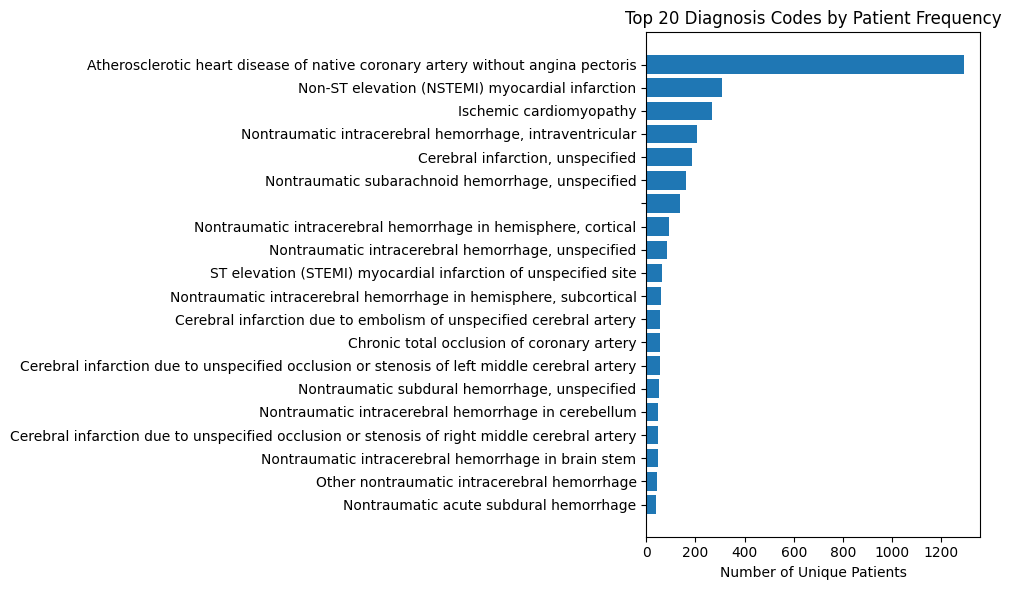

In [29]:

# Bar plot of top 20 dx_norms by number of unique patients
top20 = summary_df.head(20)

plt.figure(figsize=(10,6))
plt.barh(top20["dx_norm"].to_list()[::-1], top20["n_patients"].to_list()[::-1])
plt.yticks(range(20), top20["description"].to_list()[::-1])
plt.xlabel("Number of Unique Patients")
plt.title("Top 20 Diagnosis Codes by Patient Frequency")
plt.tight_layout()
plt.show()